In [1]:
# Pré-processamento inicial dos dados.

import pandas as pd

df = pd.read_csv('database.csv')
df['date'] = pd.to_datetime(df['date'])
df.drop_duplicates()
df.sort_values(by='date')
df.describe()

df = df[df['date'] >= '2025-03-01']

In [2]:
#Divisão dos dados


train_size = int(0.6 * len(df))
val_size = int(0.2 * len(df))

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

lookback_val = train_df
lookback_test = df.iloc[:len(test_df)]

In [3]:
def time_features(
    data: pd.DataFrame
    ) -> pd.DataFrame:

    data['day_of_week'] = data['date'].dt.weekday.astype(float)
    data['hour_of_day'] = data['date'].dt.hour.astype(float)

    data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    data['hour_sin'] = np.sin(2 * np.pi * data['hour_of_day'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour_of_day'] / 24) 

    data = data.drop(
        ['day_of_week','hour_of_day'],
        axis = 1)
    
    return data

In [4]:
def matchup_features(
    data: pd.DataFrame,
    n: int = 9
) -> pd.DataFrame:
    """
    Creates all features related to number of matches played and its attributes.
    """
    # Ordena por data e cria cópia segura
    data = data.sort_values('date').copy()
    
    # 1. Time since start
    data['time_since_start'] = (data['date'] - data['date'].min()).dt.days.astype(float)
    
    # 2. Last H2H (horas desde a última partida do mesmo matchup)
    data['last_h2h'] = (
        data.groupby('matchup_key')['date']
        .transform(lambda x: x.diff().dt.total_seconds() / 3600)
    )
    
    # 3. H2H Count (total acumulado de partidas por matchup)
    data['h2h_count'] = data.groupby('matchup_key').cumcount() + 1
    
    # 4. H2H N Hours Count (partidas nas últimas N horas) ***CORREÇÃO FINAL***
    data['tmp_window_start'] = data['date'] - pd.Timedelta(hours=n)
    
    # Usa merge_asof para contagem temporal eficiente
    data = data.sort_values('date')
    data[f'h2h_{n}h_count'] = (
        data.groupby('matchup_key', group_keys=False)
        .apply(
            lambda grp: grp.apply(
                lambda row: grp[
                    (grp['date'] > row['tmp_window_start']) & 
                    (grp['date'] < row['date'])
                ].shape[0],
                axis=1
            )
        )
    ).astype(int)
    
    # 5. Is Return Match (verifica se é revanche imediata)
    data['current_pair'] = data.apply(
        lambda x: tuple(sorted([x['home_team'], x['away_team']])), 
        axis=1
    )
    data['previous_pair'] = data.groupby('matchup_key')['current_pair'].shift(1)
    data['is_return_match'] = (data['current_pair'] == data['previous_pair']).astype(int).fillna(0)
    
    # Remove colunas auxiliares
    return data.drop(['current_pair', 'previous_pair', 'tmp_window_start'], axis=1)

In [5]:
def goal_features(
    data: pd.DataFrame, 
    pace: bool, 
    normalize: bool,
    live: bool
    ) -> pd.DataFrame: 
    
    """
    if not REQUIRED_COLUMNS.issubset(data.columns):
        logging.error(f"DataFrame must contain the following columns: {REQUIRED_COLUMNS}") 
    """

    data = data.copy()

    
    data["original_total_score"] = data["total_score"].copy()

    if normalize == True:
        data['total_score'] = data['total_score'] / data['league'].map(pace)

    if live == False:
        data['total_score'] = data.groupby('matchup_key')['total_score'].shift()
    
    #  Extrai posições do matchup_key
    data['home_pos'] = data['matchup_key'].str[0]
    data['away_pos'] = data['matchup_key'].str[1]
        
    # Define scores dinamicamente para cada posição
    data['score_home_pos'] = np.where(
        data['home_pos'] == data['home_team'],  # Condição
        data['home_score'],                      # Valor se True
        data['away_score']                       # Valor se False
    )
        
    data['score_away_pos'] = np.where(
        data['away_pos'] == data['away_team'],
        data['away_score'],
        data['home_score']
    )

    def lags(data: pd.DataFrame = data) -> pd.DataFrame:
        """
        Creates lags for the data
        L1 = Last Match total Score
        L2 = Last 2 Match total Score
        L3 = Last 3 Match total Score

        Creates a new column for each lag, with the lag number.
        TODO: Make this dynamic, so it can be used for any number of lags.
        """
        max_lags = 3
        for lag in range(1, max_lags + 1):
            data[f'l{lag}'] = data.groupby('matchup_key')['total_score'].shift(lag)
        
        return data

    def rolling_stats(data: pd.DataFrame = data, window: int = 3) -> pd.DataFrame:
        
        """
        Creates rolling statistics for the data
        window: Matches that will be used to calculate the statistic
        returns a new column for each statistic: median, std, avg
        """
        
        stats = {
            f'median_{window}': lambda x: x.rolling(window).median(),
            f'std_{window}': lambda x: x.rolling(window).std(ddof=0),
            f'avg_{window}': lambda x: x.rolling(window).mean(),
        }

        for name, func in stats.items():
            data[name] = data.groupby('matchup_key')['total_score'].transform(func)
        
        return data

    def ewma(data: pd.DataFrame = data, alpha: float = 0.03) -> pd.DataFrame:
        
        """
        Creates a EWMA with the final_score of past matches.
        alpha: intensity weighted on most recent matches
        """

        data[f'ewma_{alpha}'] = data.groupby('matchup_key')['total_score'].transform(
            lambda x: x.ewm(alpha=alpha, adjust=False).mean()
            )
        
        return data

    def cumulative_stats(data: pd.DataFrame = data) -> pd.DataFrame:

        """
        Creates cumulative statistics for the data
        Uses all data to calculate the statistic
        returns a new column for each statistic: median, std, avg
        """
        
        stats = {
            'median': lambda x: x.expanding().median(),
            'std': lambda x: x.expanding().std(ddof=0),
            'avg': lambda x: x.expanding().mean(),
        }

        for name, func in stats.items():
            data[name] = data.groupby('matchup_key')['total_score'].transform(func)
        
        return data
    
    def rolling_stats_indv(data: pd.DataFrame, window: int = 3) -> pd.DataFrame:
        """
        Cria estatísticas rolantes seguras contra data leakage:
        - Ordena por data dentro de cada grupo
        - Usa janela fechada à esquerda (closed='left')
        - Adiciona shift(1) para excluir valor atual
        """
        data = data.sort_values('date').copy()
        
        # Novo dicionário de estatísticas com proteção contra leakage
        stats = {
            'median': lambda x: (
                x.rolling(window, min_periods=1, closed='left')
                .median()
            ),
            'std': lambda x: (
                x.rolling(window, min_periods=1, closed='left')
                .std(ddof=0)
                .shift(1)
            ),
            'avg': lambda x: (
                x.rolling(window, min_periods=1, closed='left')
                .mean()
            )
        }

        # Cálculo para home_pos
        for stat, func in stats.items():
            data[f'{stat}_{window}_home_pos'] = (
                data.groupby('home_pos', group_keys=False)['score_home_pos']
                .transform(func)
            )
        
        # Cálculo para away_pos
        for stat, func in stats.items():
            data[f'{stat}_{window}_away_pos'] = (
                data.groupby('away_pos', group_keys=False)['score_away_pos']
                .transform(func)
            )
        
        return data

    def consistency(data: pd.DataFrame, window: int =3) -> pd.DataFrame:     
        data[f'consistency_{window}_home_pos'] = data[f'avg_{window}_home_pos'] / (data[f'std_{window}_home_pos'] + 1e-6).clip(lower=-10,upper=10)
        data[f'consistency_{window}_away_pos'] = data[f'avg_{window}_away_pos'] / (data[f'std_{window}_away_pos'] + 1e-6).clip(lower=-10,upper=10)
        return data

    def deltas(data: pd.DataFrame, lower: int = 3, upper: int = 10, metric: str = 'avg') ->pd.DataFrame:
        window = f'{upper}-{lower}'
        data[f'delta_{metric}_{window}_home_pos'] = data[f'{metric}_{lower}_home_pos'] - data[f'{metric}_{upper}_home_pos']
        data[f'delta_{metric}_{window}_away_pos'] = data[f'{metric}_{lower}_away_pos'] - data[f'{metric}_{upper}_away_pos']
        return data

    #data = lags(data)
    #data = rolling_stats(data, window=3)
    #data = rolling_stats(data, window=10)
    data = rolling_stats_indv(data, window=10)
    data = rolling_stats_indv(data, window=3)
    #data = consistency(data, window=3)
    #data = consistency(data, window=10)
    #data = deltas(data, metric='avg')
    #data = deltas(data, metric='std')
    #data = ewma(data, alpha=0.03)
    #data = ewma(data, alpha=0.15)
    #data = cumulative_stats(data)

    data["total_score"] = data["original_total_score"]
    data = data.drop(columns=["original_total_score"])  


    return data   


In [6]:
def matchup_key(row):
    """Creates a column with the matchup key for the two players"""
    return tuple(sorted([
    str(row['home_player']).lower(),
    str(row['away_player']).lower()]))

In [7]:
def features(
    data: pd.DataFrame,
    lookback_data: pd.DataFrame | None = None,
    live: bool = True,
    normalize: bool = False,
    pace: bool = False,
    players: tuple[str, str] = ('', '')
    ) -> pd.DataFrame:
    
    """
    Creates all features for the model
    
    If lookback_data is provided, it will be used to create the features:
        - original_data will be marked as True
        - lookback_data will be marked as False
        - both will be concatenated and sorted by date
        - at the end, lookback_data will be dropped
    
    If live is True, it will return the last match of the two players.

    1- Creates and asserts matchup_key is a tuple of the two players;
    2- Assert date is a datetime object and sorts by date;
    3- Creates all time-related features;
    4- Creates all goal-related features;
    5- Returns the dataframe with the new features appended.
    """

    #TODO: Fix normalize param

    data = data.copy()


    data['matchup_key'] = data.apply(matchup_key, axis=1)   
    data = data.sort_values(['matchup_key', 'date']).reset_index(drop=True)
    
    if lookback_data is not None:
        original_data = data.copy()
        original_data['__original__'] = True

        lookback_data = lookback_data.copy()
        lookback_data['__original__'] = False
        lookback_data['matchup_key'] = lookback_data.apply(matchup_key, axis=1)  # Correção aqui
        
        data = pd.concat([original_data, lookback_data], ignore_index=True)

    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['date']).reset_index(drop=True)
    
    #data = time_features(data)
    data = matchup_features(data)
    data = goal_features(data, pace, normalize, live)
    
    if lookback_data is not None:
        data = data[data['__original__']].drop(columns=['__original__'])
        data = data.reset_index(drop=True)

    if live == True: 
        try:  
            data = data[data['matchup_key'] == players]
            current_match = data.tail(1)
            return current_match
        
        except:
            raise ValueError(f"Players {players} not found in the data")

    return data

In [8]:
REQUIRED_FEATURES = [
    
    # Time-based OG features
    'h2h_count', 'last_h2h', 'time_since_start',
    
    #'day_sin', 'day_cos',
    #'hour_sin', 'hour_cos',
    

    # Goal-based OG features
    #'l1', 'l2', 'l3', 
    #'median','std', 'avg',
    #'ewma_0.15', 'ewma_0.03',
    #'max_5', 'min_5', 'delta_5'
    #'median_3', 'std_3', 'avg_3',

    # New Features
    'h2h_9h_count', #'is_return_match',
    'avg_3_home_pos', 'avg_3_away_pos', 
    'avg_10_home_pos','avg_10_away_pos',  
    'std_3_home_pos','std_3_away_pos',
    'std_10_home_pos','std_10_away_pos', 
    
    #'median_3_home_pos','median_3_away_pos','median_10_home_pos', 'median_10_away_pos',
     
]

COLUMNS_DROP = [
    'Unnamed: 0', 'event_id', 'date', 'away_team', 'away_player',
    'away_score', 'home_team', 'home_player', 'home_score', 'total_score',
    'home_pos', 'away_pos', 'score_home_pos', 'score_away_pos', 'matchup_key',
    

    'median_3_home_pos', 'median_3_away_pos',
    'median_10_home_pos', 'median_10_away_pos',
]

In [9]:
#Criar Features para cada um dos dados.
#TODO: Normalizar?


train_featured = features(
    data=train_df,live=False
    ).dropna()

val_featured = features(
    data=val_df, live=False, 
    lookback_data=train_df
    ).dropna()

test_featured = features(
    data=test_df, live=False, 
    lookback_data=lookback_test
    ).dropna()

C:\Users\Enzo\AppData\Local\Temp\ipykernel_23908\3030190685.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


NameError: name 'np' is not defined

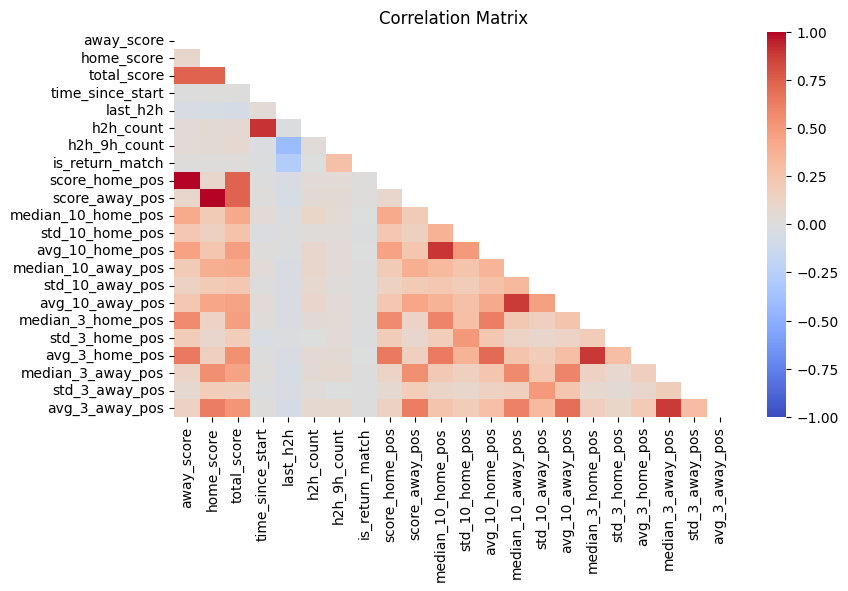

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Calcular matriz de correlação (use Spearman para relações não-lineares)
corr_matrix = train_featured.drop(columns=["event_id", "date", "Unnamed: 0"]).select_dtypes(include=np.number).corr(method="pearson")

# Visualizar heatmap
plt.figure(figsize=(9, 5))
sns.heatmap(
    corr_matrix, 
    annot=False, 
    cmap="coolwarm", 
    vmin=-1, 
    vmax=1,
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mascarar triângulo superior
)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
#Divisão dos dados em X e y

train_X = train_featured.drop(columns=COLUMNS_DROP)
train_y = train_featured['total_score']

val_X = test_featured.drop(columns=COLUMNS_DROP)
val_y = test_featured['total_score']

test_X = val_featured.drop(columns=COLUMNS_DROP)
test_y = val_featured['total_score']

#Dividir a validação em dois blocos.

val_X_1, val_X_2 = val_X[:len(val_X)//2], val_X[len(val_X)//2:]
val_y_1, val_y_2 = val_y[:len(val_y)//2], val_y[len(val_y)//2:]

final_train_X = pd.concat([train_X, val_X_1])
final_train_y = pd.concat([train_y, val_y_1])


In [ ]:
#  Salvar xlsx Test Set
test_X.to_excel('test_dataset.xlsx', index=False)

In [ ]:
#Definir Poisson log loss
import numpy as np
from scipy.stats import poisson

def poisson_log_loss(y_true, y_pred):

    prob = np.array([poisson.pmf(k, y_pred) for k in y_true])
    return -np.mean(np.log(prob + 1e-10)) 


In [ ]:
#Definir pesos
import numpy as np

pesos_treinamento = np.linspace(0.5, 1, num=len(train_X))
pesos_validacao = np.linspace(0.7, 1, num=len(val_X))

In [ ]:
#  Definir parâmetros Random Search
from scipy import stats
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

tscv =  TimeSeriesSplit(n_splits=5)

custom_scorer = make_scorer(
    poisson_log_loss,
    greater_is_better=False
)

param_dist = {
    'learning_rate': stats.loguniform(0.01, 0.1),  # Aumente o mínimo para 0.01
    'max_depth': stats.randint(4, 7),              # Permita árvores mais profundas
    'subsample': stats.uniform(0.7, 0.2),          # Reduza o intervalo para 0.7-0.9
    'gamma': stats.expon(scale=0.7),             # Reduza a escala para evitar splits irrelevantes
    'reg_alpha': stats.expon(scale=20),             # Regularização L1 mais restritiva
    'reg_lambda': stats.expon(scale=40),
    'n_estimators': stats.randint(300, 800)        # Reduza o limite superior
}

random_model = XGBRegressor(
    objective='reg:tweedie',
    eval_metric='poisson-nloglik',
    tree_method='hist',
    early_stopping_rounds=50,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=random_model,
    param_distributions=param_dist,
    n_iter=150,
    scoring=custom_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
#Treinar Modelo Random Search
from datetime import datetime
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error

random_search.fit(
    train_X, train_y,
    #sample_weight=pesos_treinamento,
    eval_set=[(val_X_1, val_y_1)],
    verbose=2
)

best_random_model = random_search.best_estimator_
best_random_params = random_search.best_params_

final_random_model = XGBRegressor(
    **best_random_params,
    objective='reg:tweedie',
    eval_metric='poisson-nloglik',
    tree_method='hist',
    early_stopping_rounds=50,
    random_state=42
)

final_random_model.fit(
    final_train_X, final_train_y,
    eval_set=[(val_X_2,val_y_2)],
    verbose=10
)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[0]	validation_0-poisson-nloglik:2.15058
[2]	validation_0-poisson-nloglik:2.12459
[4]	validation_0-poisson-nloglik:2.10127
[6]	validation_0-poisson-nloglik:2.08071
[8]	validation_0-poisson-nloglik:2.06246
[10]	validation_0-poisson-nloglik:2.04575
[12]	validation_0-poisson-nloglik:2.03080
[14]	validation_0-poisson-nloglik:2.01799
[16]	validation_0-poisson-nloglik:2.00669
[18]	validation_0-poisson-nloglik:1.99596
[20]	validation_0-poisson-nloglik:1.98667
[22]	validation_0-poisson-nloglik:1.97851
[24]	validation_0-poisson-nloglik:1.97089
[26]	validation_0-poisson-nloglik:1.96424
[28]	validation_0-poisson-nloglik:1.95793
[30]	validation_0-poisson-nloglik:1.95252
[32]	validation_0-poisson-nloglik:1.94769
[34]	validation_0-poisson-nloglik:1.94340
[36]	validation_0-poisson-nloglik:1.93920
[38]	validation_0-poisson-nloglik:1.93600
[40]	validation_0-poisson-nloglik:1.93287
[42]	validation_0-poisson-nloglik:1.92961
[44]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='poisson-nloglik',
             feature_types=None, gamma=np.float64(1.189638850847455),
             grow_policy=None, importance_type=None,
             interaction_constraints=None,
             learning_rate=np.float64(0.035908793342403184), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=301, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [ ]:
test_pred_random_model = final_random_model.predict(test_X)

print(60 * '-')
print('Teste:')
print(f"MAE: {mean_absolute_error(test_y, test_pred_random_model):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, test_pred_random_model)):.4f}")
print(f"Log Loss: {poisson_log_loss(test_y, test_pred_random_model):.4f}")

------------------------------------------------------------
Teste:
MAE: 1.1961
RMSE: 1.5249
Log Loss: 2.3270


Teste:
MAE: 1.4916
RMSE: 1.8398
Log Loss: 2.1984

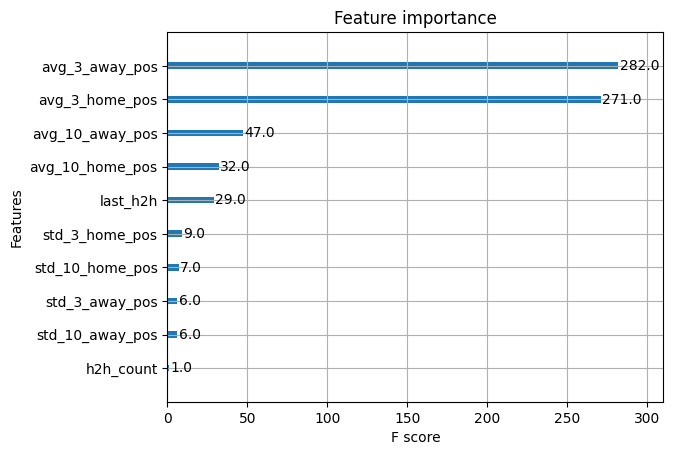

In [ ]:
plot_importance(final_random_model,max_num_features=50)
plt.show()
best_random_model.save_model('model_22614.json')

In [ ]:
from pprint import pprint

print(60 * '-')
print('Parametros Escolhidos:')
pprint(best_random_params)
print(60 * '-')

------------------------------------------------------------
Parametros Escolhidos:
{'gamma': np.float64(1.189638850847455),
 'learning_rate': np.float64(0.035908793342403184),
 'max_depth': 4,
 'n_estimators': 301,
 'reg_alpha': np.float64(111.73973056250375),
 'reg_lambda': np.float64(134.5784415672155),
 'subsample': np.float64(0.8116586907214195)}
------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np

# Crie grupos (ex: previsões de 0 a 5 gols, em intervalos de 1 gol)
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
df_test = pd.DataFrame({'Previsão': test_pred_random_model, 'Real': test_y})
df_test['Grupo'] = pd.cut(df_test['Previsão'], bins=bins)

# Calcule o Log Loss para cada grupo
log_loss_por_grupo = df_test.groupby('Grupo').apply(
    lambda x: poisson_log_loss(x['Real'], x['Previsão'])
)
print(log_loss_por_grupo)

C:\Users\Enzo\AppData\Local\Temp\ipykernel_14604\1884235783.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  log_loss_por_grupo = df_test.groupby('Grupo').apply(
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Grupo
(0, 1]         NaN
(1, 2]         NaN
(2, 3]    1.716625
(3, 4]    1.819514
(4, 5]    1.925686
(5, 6]    2.030778
(6, 7]    2.152661
(7, 8]    2.298782
dtype: float64


C:\Users\Enzo\AppData\Local\Temp\ipykernel_14604\1884235783.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  log_loss_por_grupo = df_test.groupby('Grupo').apply(


In [ ]:
# Calcule a média real para cada grupo de previsão
calibracao = df_test.groupby('Grupo')['Real'].mean().reset_index()
calibracao.columns = ['Grupo', 'Média Real']
print(calibracao)

    Grupo  Média Real
0  (0, 1]         NaN
1  (1, 2]         NaN
2  (2, 3]    2.363844
3  (3, 4]    3.604494
4  (4, 5]    4.432956
5  (5, 6]    5.441708
6  (6, 7]    6.629032
7  (7, 8]    8.469388


C:\Users\Enzo\AppData\Local\Temp\ipykernel_14604\3683552807.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibracao = df_test.groupby('Grupo')['Real'].mean().reset_index()


Frequência relativa dos gols totais:
Gols: 0 - Frequência relativa: 1.06%
Gols: 1 - Frequência relativa: 4.30%
Gols: 2 - Frequência relativa: 10.59%
Gols: 3 - Frequência relativa: 17.09%
Gols: 4 - Frequência relativa: 19.26%
Gols: 5 - Frequência relativa: 17.22%
Gols: 6 - Frequência relativa: 13.13%
Gols: 7 - Frequência relativa: 8.96%
Gols: 8 - Frequência relativa: 4.39%
Gols: 9 - Frequência relativa: 2.24%
Gols: 10 - Frequência relativa: 1.10%
Gols: 11 - Frequência relativa: 0.46%
Gols: 12 - Frequência relativa: 0.15%
Gols: 13 - Frequência relativa: 0.05%
Gols: 14 - Frequência relativa: 0.01%


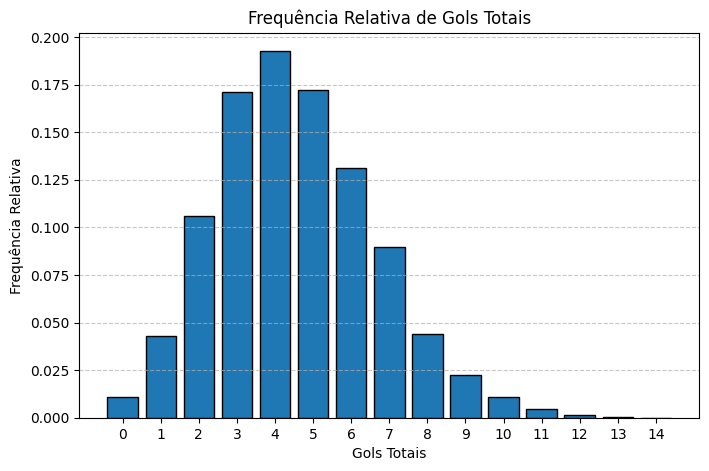

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Remover valores NaN
gols_totais = df['total_score'].dropna()

# Arredondar os valores (você pode ajustar isso se quiser manter decimais)
gols_agrupados = gols_totais.round(0).astype(int)

# Calcular frequência relativa
frequencia_relativa = gols_agrupados.value_counts(normalize=True).sort_index()

# Exibir as frequências relativas por escrito
print("Frequência relativa dos gols totais:")
for valor, freq in frequencia_relativa.items():
    print(f"Gols: {valor} - Frequência relativa: {freq:.2%}")

# Plotar o gráfico de barras com frequência relativa
plt.figure(figsize=(8, 5))
plt.bar(frequencia_relativa.index, frequencia_relativa.values, edgecolor='black')
plt.title('Frequência Relativa de Gols Totais')
plt.xlabel('Gols Totais')
plt.ylabel('Frequência Relativa')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(frequencia_relativa.index)
plt.show()


In [ ]:
# Remover valores NaN para evitar erros
gols_totais = df['total_score'].dropna()

# Média
media = gols_totais.mean()

# Variância
variancia = gols_totais.var()

print(f"Média dos gols totais: {media:.2f}")
print(f"Variância dos gols totais: {variancia:.2f}")
print('Desvio padrão: ', gols_totais.std())


Média dos gols totais: 4.55
Variância dos gols totais: 4.37
Desvio padrão:  2.0915855674404273


In [ ]:
"""
#Exportar modelo para arquivo xlsx.

test_pred_df = pd.DataFrame(test_pred_random_model, columns=['predited']).reset_index(drop=True)
test_y_df = pd.DataFrame(test_y, columns=['total_score']).reset_index(drop=True)
test_X_df = pd.DataFrame(test_X, columns=REQUIRED_FEATURES).reset_index(drop=True)
df_to_export = pd.concat([test_y_df, test_pred_df, test_X_df], axis=1)

df_to_export.to_excel(f'training_testing/dados/exports/final_random_df {datetime.now().strftime('%d-%m %H-%M')}.xlsx', index=False)
final_random_model.save_model("modelo_xgb.json") 
"""

'\n#Exportar modelo para arquivo xlsx.\n\ntest_pred_df = pd.DataFrame(test_pred_random_model, columns=[\'predited\']).reset_index(drop=True)\ntest_y_df = pd.DataFrame(test_y, columns=[\'total_score\']).reset_index(drop=True)\ntest_X_df = pd.DataFrame(test_X, columns=REQUIRED_FEATURES).reset_index(drop=True)\ndf_to_export = pd.concat([test_y_df, test_pred_df, test_X_df], axis=1)\n\ndf_to_export.to_excel(f\'training_testing/dados/exports/final_random_df {datetime.now().strftime(\'%d-%m %H-%M\')}.xlsx\', index=False)\nfinal_random_model.save_model("modelo_xgb.json") \n'

Treinamento do Modelo baseado em Grid Search

In [ ]:
"""
grid_search.fit(train_X, train_y)

best_grid_model = grid_search.best_estimator_
best_grid_params = grid_search.best_params_

final_grid_model = XGBRegressor(
    **best_grid_params,
    early_stopping_rounds=50,
    objective='count:poisson',
    eval_metric='poisson-nloglik'
    )

final_grid_model.fit(
    final_train_X, final_train_y,
    eval_set=[(val_X_2, val_y_2)],
    verbose=10
)

test_pred_grid_model = final_grid_model.predict(test_X)


print(60 * '-')
print('Teste:')
print(f"MAE: {mean_absolute_error(test_y, test_pred_grid_model):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, test_pred_grid_model)):.4f}")
print(f"Log Loss: {poisson_log_loss(test_y, test_pred_grid_model):.4f}")

plot_importance(final_grid_model)
plt.show()
"""

'\ngrid_search.fit(train_X, train_y)\n\nbest_grid_model = grid_search.best_estimator_\nbest_grid_params = grid_search.best_params_\n\nfinal_grid_model = XGBRegressor(\n    **best_grid_params,\n    early_stopping_rounds=50,\n    objective=\'count:poisson\',\n    eval_metric=\'poisson-nloglik\'\n    )\n\nfinal_grid_model.fit(\n    final_train_X, final_train_y,\n    eval_set=[(val_X_2, val_y_2)],\n    verbose=10\n)\n\ntest_pred_grid_model = final_grid_model.predict(test_X)\n\n\nprint(60 * \'-\')\nprint(\'Teste:\')\nprint(f"MAE: {mean_absolute_error(test_y, test_pred_grid_model):.4f}")\nprint(f"RMSE: {np.sqrt(mean_squared_error(test_y, test_pred_grid_model)):.4f}")\nprint(f"Log Loss: {poisson_log_loss(test_y, test_pred_grid_model):.4f}")\n\nplot_importance(final_grid_model)\nplt.show()\n'

In [ ]:
"""
#Exportar modelo para arquivo xlsx.

test_pred_df = pd.DataFrame(test_pred_random_model, columns=['lambda']).reset_index(drop=True)
test_y_df = pd.DataFrame(test_y, columns=['total_score']).reset_index(drop=True)
test_X_df = pd.DataFrame(test_X, columns=REQUIRED_FEATURES).reset_index(drop=True)
df_to_export = pd.concat([test_y_df, test_pred_df, test_X_df], axis=1)

df_to_export.to_excel(f'training_testing/dados/exports/final_random_df {datetime.now().strftime('%d-%m %H-%M')}.xlsx', index=False)
"""

"\n#Exportar modelo para arquivo xlsx.\n\ntest_pred_df = pd.DataFrame(test_pred_random_model, columns=['lambda']).reset_index(drop=True)\ntest_y_df = pd.DataFrame(test_y, columns=['total_score']).reset_index(drop=True)\ntest_X_df = pd.DataFrame(test_X, columns=REQUIRED_FEATURES).reset_index(drop=True)\ndf_to_export = pd.concat([test_y_df, test_pred_df, test_X_df], axis=1)\n\ndf_to_export.to_excel(f'training_testing/dados/exports/final_random_df {datetime.now().strftime('%d-%m %H-%M')}.xlsx', index=False)\n"